In this notebook, I'll go through a full example of using bpnet-multi to analyze some chip-nexus data. These are the same data that were used in our original paper: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

You can download the data from https://zenodo.org/record/3371216#.Y0muwFLMKAQ , but be aware that it's 30 GB of data. 
I (Charles McAnany) also have a local copy at Stowers, so if you're at Stowers, just let me know and I'll point you in the right direction. 
I've copied the idr-optimal-set.summit.bed files and the counts.neg.bw and counts.pos.bw files from the downloaded data into my working directory. 

In [168]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,4]
plt.rcParams['figure.dpi'] = 150
import numpy as np
import pyBigWig
import pysam

In [4]:
#Here, I'll set a few constants that will be applicable throughout the project. 
WORKING_DIRECTORY="/scratch/cm2363/oskn-demo"
SRC_DIR="/n/projects/cm2363/chrombpnet-heavy/src"
GENOME_FASTA=WORKING_DIRECTORY + "/data/all_chr.fa"
TF_NAMES = ["oct4", "sox2", "klf4", "nanog"] #The names of the factors we'll use. For consistency, I'm always going to use lowercase. 
TEST_CHROMS = ["chr" + str(x) for x in [1,8,9]]
VAL_CHROMS = ["chr" + str(x) for x in [2,3,4]]
TRAIN_CHROMS = ["chr" + str(x) for x in [5,6,7,10,11,12,13,14,15,16,17,18,19]]

In [23]:
!ls -l {WORKING_DIRECTORY}

total 4
drwxr-xr-x 2 cm2363 Domain Users   10 Oct 14 14:30 bed
drwxr-xr-x 2 cm2363 Domain Users 4096 Oct 14 13:59 data
drwxr-xr-x 2 cm2363 Domain Users   10 Oct 14 14:30 json
drwxr-xr-x 2 cm2363 Domain Users   10 Oct 14 14:30 models
drwxr-xr-x 2 cm2363 Domain Users   10 Oct 14 14:30 pred
drwxr-xr-x 2 cm2363 Domain Users   10 Oct 14 14:30 shap


In [27]:
!ls -lh {WORKING_DIRECTORY}/data

total 3.5G
-rw-r----- 1 cm2363 Domain Users 350M Oct 14 13:52 klf4.neg.bw
-rw-r----- 1 cm2363 Domain Users 350M Oct 14 13:56 klf4.pos.bw
-rw-r----- 1 cm2363 Domain Users 1.4M Oct 14 13:57 klf4.summit.bed
-rw-r----- 1 cm2363 Domain Users 398M Oct 14 13:58 nanog.neg.bw
-rw-r----- 1 cm2363 Domain Users 398M Oct 14 13:59 nanog.pos.bw
-rw-r----- 1 cm2363 Domain Users 1.3M Oct 14 13:58 nanog.summit.bed
-rw-r----- 1 cm2363 Domain Users 551M Oct 14 13:57 oct4.neg.bw
-rw-r----- 1 cm2363 Domain Users 551M Oct 14 13:57 oct4.pos.bw
-rw-r----- 1 cm2363 Domain Users 604K Oct 14 13:58 oct4.summit.bed
-rw-r----- 1 cm2363 Domain Users 154M Oct 14 13:59 patchcap.neg.bw
-rw-r----- 1 cm2363 Domain Users 154M Oct 14 13:59 patchcap.pos.bw
-rw-r----- 1 cm2363 Domain Users 301M Oct 14 13:58 sox2.neg.bw
-rw-r----- 1 cm2363 Domain Users 300M Oct 14 13:58 sox2.pos.bw
-rw-r----- 1 cm2363 Domain Users 257K Oct 14 13:58 sox2.summit.bed


In [ ]:
#The first thing I need to do is prepare input files in order to train a bias model. 
#But what shall I use for bias? I have two options: I can either use background regions from the actual chip-nexus experiments,
#or I can use the patchcap track. 
#If I were to use background regions, I'd have to have a stringent way to determine when a region is not bound, and the data
#are noisy enough that this might be a tough call. I'll train up the bias model on patchcap data instead. 

#In order to train that model, I'll need a couple things:
# 1. The bias data. I'm going to just use the patchcap bigwigs from the paper, no biggie. 
# 2. A set of regions to train on. I'll make these in a minute. 
# 3. A model architecture. I have to decide on this right now, because it will determine the size of the regions I train on. 

#I'll use a standard BPNet architecture, but with few filters since it's learning something so simple. 
#With a 9-layer network, and a 25 bp input filter and 25 bp output filter, using 1000 bp output windows, I can calculate the input size:

In [166]:
OUTPUT_LENGTH=1000
input_length_str = !{SRC_DIR}/lengthCalc.py --output-len {OUTPUT_LENGTH} --n-dil-layers 9 --conv1-kernel-size 25 --profile-kernel-size 25
INPUT_LENGTH=int(input_length_str[0])
print(INPUT_LENGTH)
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH+1
print(RECEPTIVE_FIELD)

3092
2093


In [6]:
#Okay, great. I need to make sure that the regions I train on have valid DNA within 3092/2 bases of the middle of the window. 
#For clarity, here are some dimensions:

#
#
#            |<---  2093 bp (Receptive field) --->|
#   |<--------------------   3092 bp (Input length) ----------------------->|
#   SEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCE
#   \        \                                    /                        /
#     \        \                                /                        /
#       \        \                            /                        / 
#         \        \                        /                        / 
#           \        \                    /                        / 
#             \        \                /                        / 
#               \        \            /                        / 
#                 \        \        /                        / 
#                   \        \    /                        /
#                     \        \/                        /
#                      PROFILEPROFILEPROFILEPROFILEPROFIL
#                      |<--- 1000 bp (Output length) --->|
#    |<--- 1046 bp --->|
#
# During training, we also shift the regions around by a little bit, a process called jittering. We'll use a maximum jitter of 100.
MAX_JITTER=100

In [ ]:
#In order to generate bias regions, I need to get the actual training regions. This is not really part of bpnet-multi, but 
#I do have a few utility scripts in the repo to help with this. 
#I'm going to combine the called peaks, make sure there's valid genome under all of them (i.e., no "N" nucleotides within the receptive field.),
#then split them into train, validation, and test splits. 


In [7]:
bigwigFileNames = [WORKING_DIRECTORY + "/data/" + tfName + "." + strand + ".bw" for tfName in TF_NAMES for strand in ["pos", "neg"]]
print(bigwigFileNames)
summitBedFnames = [WORKING_DIRECTORY + "/data/" + tfName + ".summit.bed" for tfName in TF_NAMES]
print(summitBedFnames)

['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw', '/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw', '/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw', '/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw']
['/scratch/cm2363/oskn-demo/data/oct4.summit.bed', '/scratch/cm2363/oskn-demo/data/sox2.summit.bed', '/scratch/cm2363/oskn-demo/data/klf4.summit.bed', '/scratch/cm2363/oskn-demo/data/nanog.summit.bed']


In [39]:
prepareBedPeaksConfig = {
    "bigwigs" : bigwigFileNames, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : summitBedFnames},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/peak_all.stats", 
    "output-width" : OUTPUT_LENGTH,
    "input-width" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/peak", 
    "resize-mode" : "center", 
    "verbosity" : "DEBUG"}
print(prepareBedPeaksConfig)

with open(WORKING_DIRECTORY + "/json/prepareBedPeaks.json", "w") as fp:
    json.dump(prepareBedPeaksConfig, fp)

{'bigwigs': ['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw', '/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw', '/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw', '/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw'], 'splits': {'test-chroms': ['chr1', 'chr8', 'chr9'], 'val-chroms': ['chr2', 'chr3', 'chr4'], 'train-chroms': ['chr5', 'chr6', 'chr7', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], 'regions': ['/scratch/cm2363/oskn-demo/data/oct4.summit.bed', '/scratch/cm2363/oskn-demo/data/sox2.summit.bed', '/scratch/cm2363/oskn-demo/data/klf4.summit.bed', '/scratch/cm2363/oskn-demo/data/nanog.summit.bed']}, 'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'write-counts-to': '/scratch/cm2363/oskn-demo/bed/peak_all.stats', 'output-width': 1000, 'input-width': 3092, 'max-jitter'

In [47]:
!ls {WORKING_DIRECTORY}/json

prepareBedPeaks.json


In [48]:
#Now we can go ahead and run that script. 
!{SRC_DIR}/prepareBed.py {WORKING_DIRECTORY}/json/prepareBedPeaks.json

INFO:root:Starting bed file generation.
INFO:root:Rejected on loading: 2934
INFO:root:Regions loaded.
INFO:root:Validating regions.
100%|█████████████████████████████████▉| 147925/147974 [03:33<00:00, 679.61it/s]INFO:root:Regions validated. Writing to disk.
INFO:root:Regions saved.
INFO:root:Writing statistics.
100%|██████████████████████████████████| 147974/147974 [03:34<00:00, 690.41it/s]


In [41]:
#Now that we have a bed file with all of our training regions in it, we can generate the background regions that we'll train the bias model on. 
#Note that even though I'm using patchcap data for my bias track, I'm still going to train the bias model on unbound regions, so that any effect 
#TF binding has on patchcap doesn't show up in my bias model. 
#This is another script I wrote, it generates tiling regions across the whole genome and then removes regions that overlap your peak set, 
#and also only outputs regions that fall in a set percentile of counts. 
biasBigwigFnames = [[WORKING_DIRECTORY + "/data/" + tfName + "." + strand + ".bw" for strand in ["pos", "neg"]]
                    for tfName in ["patchcap"] + TF_NAMES]
print(biasBigwigFnames)
allowChroms = TEST_CHROMS + TRAIN_CHROMS + VAL_CHROMS
#The quantile bounds limit which regions can be output by the generator. 
quantileBounds = [[0.05, 0.95], #5th to 95th percentile of counts for patchap allowed.
                  [0.1, 0.5], [0.1, 0.5], [0.1, 0.5], [0.1, 0.5]] #The TFs can be from the 10th to 50th percentile in counts. 


[['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], ['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw'], ['/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw'], ['/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw'], ['/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw']]


In [42]:
generateBiasRegionsConfig = {"head-bigwigs" : biasBigwigFnames, 
                             "allow-chroms" : allowChroms, 
                             "genome" : GENOME_FASTA,
                             "bed-files" : [WORKING_DIRECTORY + "/bed/peak_all.bed"],
                             "quantile-bounds" : quantileBounds,
                             "output-bed" : WORKING_DIRECTORY + "/bed/nonpeak_candidate.bed", 
                             "output-width" : OUTPUT_LENGTH, 
                             "edge-boundary" : 10000, #Don't include regions within 10 kb of the chromosome edge.
                             "min-spacing" : 5000, #Bias regions must be 5 kb apart.
                             "input-width" : INPUT_LENGTH,
                             "max-jitter" : MAX_JITTER,
                             "verbosity" : "DEBUG"}
with open(WORKING_DIRECTORY + "/json/generateBiasRegions.json", "w") as fp:
    json.dump(generateBiasRegionsConfig, fp)

In [58]:
!{SRC_DIR}/generateBackgroundRegions.py {WORKING_DIRECTORY}/json/generateBiasRegions.json

DEBUG:root:Preparing progress bar
INFO:root:Generating candidate regions.
300571it [00:15, 19385.60it/s]                                                  
INFO:root:Candidate regions generated.
INFO:root:Loading peaks from bed files
INFO:root:Sorting previous regions
INFO:root:Removing overlaps.
100%|██████████████████████████████| 292351/292351 [00:00<00:00, 1541253.52it/s]
INFO:root:Generating counts sums
100%|██████████████████████████████████| 236285/236285 [07:05<00:00, 554.89it/s]
(236285, 5)
['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw']
Pad         0.00       0.10       0.20       0.30       0.40       0.50       0.60       0.70       0.80       0.90       1.00 
High        0.00       6.00      10.00      12.00      13.00      15.00      16.00      17.00      19.00      22.00   83097.00 
Low         0.00       2.00       4.00       5.00       6.00       7.00       8.00       8.00      10.00      11.00   39058.00 
['/scratch/

In [43]:
#That just gave us one bed file with regions, though, so we need to split that up with prepareBed.py. 
patchcapBigwigFnames = biasBigwigFnames[0]
prepareBedNonPeaksConfig = {
    "bigwigs" : patchcapBigwigFnames, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : [WORKING_DIRECTORY + "/bed/nonpeak_candidate.bed"]},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/nonpeak_all.stats", 
    "output-width" : OUTPUT_LENGTH,
    "input-width" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/nonpeak", 
    "resize-mode" : "center", 
    "verbosity" : "DEBUG"}
print(prepareBedNonPeaksConfig)

with open(WORKING_DIRECTORY + "/json/prepareBedNonPeaks.json", "w") as fp:
    json.dump(prepareBedNonPeaksConfig, fp)

{'bigwigs': ['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], 'splits': {'test-chroms': ['chr1', 'chr8', 'chr9'], 'val-chroms': ['chr2', 'chr3', 'chr4'], 'train-chroms': ['chr5', 'chr6', 'chr7', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], 'regions': ['/scratch/cm2363/oskn-demo/bed/nonpeak_candidate.bed']}, 'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'write-counts-to': '/scratch/cm2363/oskn-demo/bed/nonpeak_all.stats', 'output-width': 1000, 'input-width': 3092, 'max-jitter': 100, 'output-prefix': '/scratch/cm2363/oskn-demo/bed/nonpeak', 'resize-mode': 'center', 'verbosity': 'DEBUG'}


In [64]:
!{SRC_DIR}/prepareBed.py {WORKING_DIRECTORY}/json/prepareBedNonPeaks.json

INFO:root:Starting bed file generation.
INFO:root:Rejected on loading: 0
INFO:root:Regions loaded.
INFO:root:Validating regions.
100%|██████████████████████████████████▊| 51188/51415 [00:19<00:00, 2615.99it/s]INFO:root:Regions validated. Writing to disk.
INFO:root:Regions saved.
INFO:root:Writing statistics.
100%|███████████████████████████████████| 51415/51415 [00:20<00:00, 2554.04it/s]


# Training the bias model

In [ ]:
#Okay, so the bed preparation step is done. I didn't spend much time on that since it will be specific to every system you deal with. 
#But now comes the common stuff. And it's (honestly) easier. 

In [45]:
#To make the model config file, I'll assemble the heads first. 
heads = []
for tfName in TF_NAMES:
    heads.append({"bigwig-files" : patchcapBigwigFnames, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10})
print(heads)

#And now the whole config file:
biasTrainConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-prefix" : WORKING_DIRECTORY + "/models/solo", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "patchcap",
            "model-args" : "",
            "filters" : 16,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "regions" : [ 
        {"bed-file" : WORKING_DIRECTORY + "/bed/nonpeak_train.bed", 
         "split" : "train",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100},
        {"bed-file" : WORKING_DIRECTORY + "/bed/nonpeak_val.bed", 
         "split" : "val",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100}],
    "heads" : heads,
    "verbosity" : "DEBUG"
}

print(biasTrainConfig)

with open(WORKING_DIRECTORY + "/json/trainBias.json", "w") as fp:
    json.dump(biasTrainConfig, fp)
    

[{'bigwig-files': ['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'patchcap_oct4', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'patchcap_sox2', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'patchcap_klf4', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'patchcap_nanog', 'counts-loss-weight': 10}]
{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-prefix': '/scratch/cm2363/oskn-demo/models/solo', 'epochs': 200, 'early-stopping-patience': 20, 'batch-size': 128

In [ ]:
!{SRC_DIR}/trainSoloModel.py {WORKING_DIRECTORY}/json/trainBias.json

In [ ]:
#(I've deleted many pages of output from the training program)
#We should look at how well the model did. 

In [10]:
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/solo.history.json --output img/solo.png

In [11]:
#It's pretty clear that the model overlearned, even with only sixteen filters. Interesting. 
#It would be great if the training and validation losses were more similar, but it's not a lethal flaw since we don't need to interpret the bias model. 
#We should, however, make predictions from it and calculate some metrics. 

# Evaluating the bias model

In [46]:
#First, we need to make predictions with the bias model. That's another json file...
biasPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/patchcap.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/solo.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(biasPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictBias.json", "w") as fp:
    json.dump(biasPredictConfig, fp)

{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-h5': '/scratch/cm2363/oskn-demo/pred/patchcap.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/scratch/cm2363/oskn-demo/models/solo.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/scratch/cm2363/oskn-demo/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [15]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictBias.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
665/665 [==============================] - 11s 12ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]
INFO:root:File saved.


In [16]:
#And now I need to convert that hdf5 file into a bigwig.
!{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/patchcap.h5 --bw {WORKING_DIRECTORY}/pred/patchcap_positive.bw --head-id 0 --task-id 0 --mode profile --verbose
!{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/patchcap.h5 --bw {WORKING_DIRECTORY}/pred/patchcap_negative.bw --head-id 0 --task-id 1 --mode profile --verbose

INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/patchcap_positive.bw, head 0 task 0
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 85120/85120 [00:00<00:00, 2210330.15it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████████| 85120/85120 [00:22<00:00, 3852.53it/s]
INFO:root:Closing bigwig.
INFO:root:Bigwig closed.
INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/patchcap_negative.bw, head 0 task 1
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 85120/85120 [00:00<00:00, 2233589.36it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████

In [ ]:
#Note that I've only written bigwigs for the first head - since all heads were trained on the same data, I'm going to assume each head performed equally well.

In [17]:
#We can now calculate some standard metrics on our predictions, though we don't yet have anything to compare these to. 
!{SRC_DIR}/metrics.py --reference {WORKING_DIRECTORY}/data/patchcap.pos.bw --pred {WORKING_DIRECTORY}/pred/patchcap_positive.bw --regions {WORKING_DIRECTORY}/bed/peak_all.bed --threads 70 --apply-abs

reference /scratch/cm2363/oskn-demo/data/patchcap.pos.bw predicted /scratch/cm2363/oskn-demo/pred/patchcap_positive.bw regions /scratch/cm2363/oskn-demo/bed/peak_all.bed
100%|██████████████████████████████████| 85120/85120 [00:05<00:00, 15598.46it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -2317.419549	     -82.841205	     -68.464914	     -54.495052	      -5.516294	85078
jsd       	       0.652046	       0.795254	       0.801888	       0.808355	       0.832501	85078
pearsonr  	      -0.052523	       0.052376	       0.081052	       0.111186	       0.356416	85078
spearmanr 	      -0.069841	       0.054946	       0.076644	       0.097606	       0.269381	85078
Counts pearson 	  0.085290
Counts spearman	  0.064329


In [32]:
#Let's also take a quick look at the generated bigwigs. 

def plotBws(bwNames, titles, chrom, start, stop):
    
    for i, bwName in enumerate(bwNames):
        plt.subplot(100*len(bwNames)+10+(i+1))
        bw = pyBigWig.open(bwName)
        bwVals = np.nan_to_num(bw.values(chrom, start, stop))
        plt.plot(bwVals)
        plt.ylabel(titles[i])
        

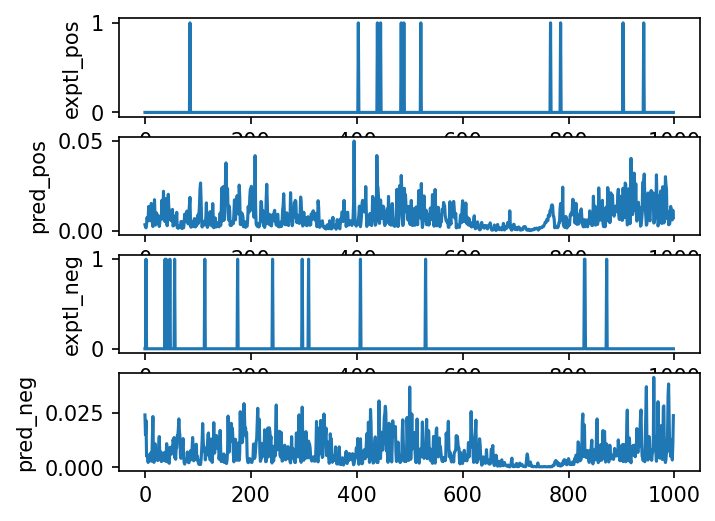

In [59]:
plotBws([WORKING_DIRECTORY + "/data/patchcap.pos.bw",
         WORKING_DIRECTORY + "/pred/patchcap_positive.bw",
         WORKING_DIRECTORY + "/data/patchcap.neg.bw", 
         WORKING_DIRECTORY + "/pred/patchcap_negative.bw"],
        ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", 34066036, 34067035)

In [ ]:
#Huh. With so little patchcap data, it's really hard to tell if the model is doing a good job.
#In any event, it's time to train the transformation model up. 


# Training the transformation model

In [48]:
heads = []
for tfName in TF_NAMES:
    heads.append({"bigwig-files" : [WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
                                    WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw"] , 
                  "profile-loss-weight" : 1, 
                  "head-name" : "transform_" + tfName,
                  "counts-loss-weight" : 10})
print(heads)

transformationTrainConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-prefix" : WORKING_DIRECTORY + "/models/transformation", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.04, #Note the very aggressive LR; we can do this because there are so few parameters. 
        "learning-rate-plateau-patience" : 5,
        "solo-model-file" : WORKING_DIRECTORY + "/models/solo.model",
        "sequence-input-length" : INPUT_LENGTH, 
        "output-length" : OUTPUT_LENGTH,
        "profile-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]},
        "counts-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]}},
        
    "regions" : [ 
        {"bed-file" : WORKING_DIRECTORY + "/bed/nonpeak_train.bed", 
         "split" : "train",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100},
        {"bed-file" : WORKING_DIRECTORY + "/bed/nonpeak_val.bed", 
         "split" : "val",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100}],
    "heads" : heads,
    "verbosity" : "DEBUG"
}

print(json.dumps(transformationTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainTransformation.json", "w") as fp:
    json.dump(transformationTrainConfig, fp)

[{'bigwig-files': ['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_oct4', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_sox2', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_klf4', 'counts-loss-weight': 10}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_nanog', 'counts-loss-weight': 10}]
{
  "settings": {
    "genome": "/scratch/cm2363/oskn-demo/data/all_chr.fa",
    "output-prefix": "/scratch/cm2363/oskn-demo/models/transformation",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-si

In [ ]:
!{SRC_DIR}/trainTransformationModel.py {WORKING_DIRECTORY}/json/trainTransformation.json

In [50]:
#Let's go ahead and make predictions...
transformPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/transform.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/transformation.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(transformPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictTransformation.json", "w") as fp:
    json.dump(transformPredictConfig, fp)


{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-h5': '/scratch/cm2363/oskn-demo/pred/transform.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/scratch/cm2363/oskn-demo/models/transformation.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/scratch/cm2363/oskn-demo/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [51]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictTransformation.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
665/665 [==============================] - 11s 12ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]
INFO:root:File saved.


In [54]:
for i, tfName in enumerate(TF_NAMES):
    !{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/transform.h5 --bw {WORKING_DIRECTORY}/pred/{tfName}_transform_positive.bw --head-id {i} --task-id 0 --mode profile --verbose 
    !{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/transform.h5 --bw {WORKING_DIRECTORY}/pred/{tfName}_transform_negative.bw --head-id {i} --task-id 1 --mode profile --verbose --negate 

INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/oct4_transform_positive.bw, head 0 task 0
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 85120/85120 [00:00<00:00, 2190825.76it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████████| 85120/85120 [00:20<00:00, 4090.69it/s]
INFO:root:Closing bigwig.
INFO:root:Bigwig closed.
INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/oct4_transform_negative.bw, head 0 task 1
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 85120/85120 [00:00<00:00, 2211932.37it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████

In [88]:
def plotTfBigwigs(tfName, exptName, startPos = 34066036, span=1000):
    plotBws([WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw", 
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw"],
            ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", startPos, startPos+span)

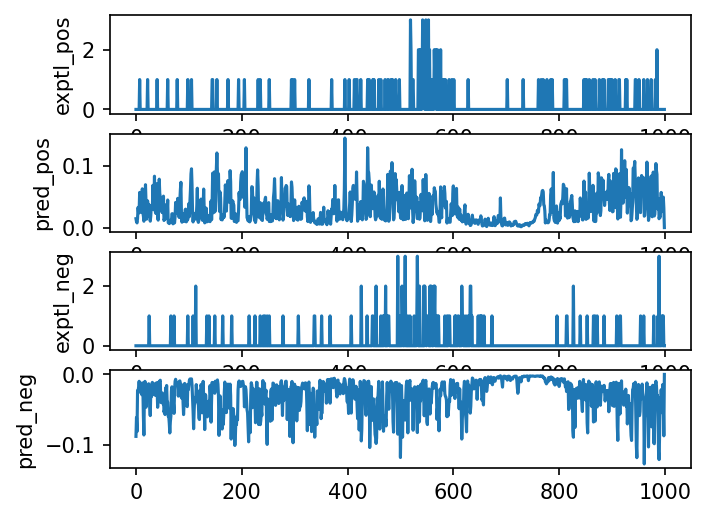

In [89]:
plotTfBigwigs('oct4', 'transform')

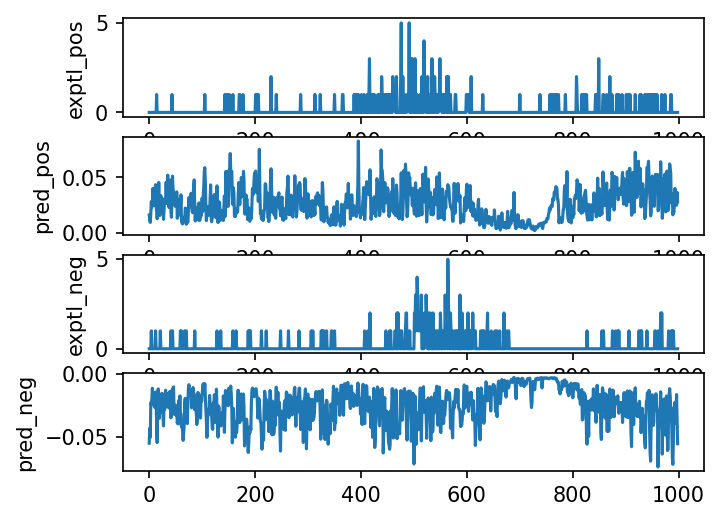

In [61]:
plotTfBigwigs('nanog', 'transform')

In [ ]:
#Of course these aren't a good match, but that's partly the point - the bald spot that the patchcap model predicts seems to also be present in the Nanog and Oct4 experimental data,
#and this suggests that that bald spot is an artifact. 

# Training the combined model

In [64]:
heads = []
for tfName in TF_NAMES:
    heads.append({"bigwig-files" : [WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
                                    WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw"] , 
                  "profile-loss-weight" : 1, 
                  "head-name" : "transform_" + tfName,
                  "counts-loss-weight" : 100, 
                  "use-bias-counts" : False})
print(heads)


#And now the whole config file:
combinedTrainConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-prefix" : WORKING_DIRECTORY + "/models/joint", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "transformation-model" : {
            "transformation-model-file" : WORKING_DIRECTORY + "/models/transformation.model"
        },
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "joint",
            "model-args" : "",
            "filters" : 64,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "regions" : [ 
        {"bed-file" : WORKING_DIRECTORY + "/bed/peak_train.bed", 
         "split" : "train",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100},
        {"bed-file" : WORKING_DIRECTORY + "/bed/peak_val.bed", 
         "split" : "val",
         "absolute-sampling-weight" : 1,
         "max-jitter" : 100}],
    "heads" : heads,
    "verbosity" : "DEBUG"
}

print(json.dumps(combinedTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainCombined.json", "w") as fp:
    json.dump(combinedTrainConfig, fp)

[{'bigwig-files': ['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_oct4', 'counts-loss-weight': 100, 'use-bias-counts': False}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_sox2', 'counts-loss-weight': 100, 'use-bias-counts': False}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_klf4', 'counts-loss-weight': 100, 'use-bias-counts': False}, {'bigwig-files': ['/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw'], 'profile-loss-weight': 1, 'head-name': 'transform_nanog', 'counts-loss-weight': 100, 'use-bias-counts': False}]
{
  "settings": {
    "genome": "/scratch/cm2363/oskn-demo/data/all_chr.fa",
    "output-prefix": "/scratch/

In [ ]:
!{SRC_DIR}/trainCombinedModel.py {WORKING_DIRECTORY}/json/trainCombined.json

In [66]:
#Let's look at the losses...
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/joint.history.json --output img/joint.png

In [ ]:
#It's overfitting a bit, maybe next time I'll try with fewer filters. 
#But now's the time to make predictions. 

In [68]:
combinedPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/combined.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(combinedPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictCombined.json", "w") as fp:
    json.dump(combinedPredictConfig, fp)
#For the residual model, I just need to change a few terms:
residualPredictConfig = combinedPredictConfig
residualPredictConfig["settings"]["output-h5"] = WORKING_DIRECTORY + "/pred/residual.h5"
residualPredictConfig["settings"]["architecture"]["model-file"] = WORKING_DIRECTORY + "/models/joint_residual.model"
with open(WORKING_DIRECTORY + "/json/predictResidual.json", "w") as fp:
    json.dump(residualPredictConfig, fp)

{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-h5': '/scratch/cm2363/oskn-demo/pred/combined.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/scratch/cm2363/oskn-demo/models/joint_combined.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/scratch/cm2363/oskn-demo/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [69]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictCombined.json
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictResidual.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
665/665 [==============================] - 36s 49ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.60it/s]
INFO:root:File saved.
INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
665/665 [==============================] - 28s 39ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|██████████████████

In [73]:
#Since rendering bigwigs takes so long, I'm going to make a little script to do it in parallel. 
commands = ["#!/usr/bin/env zsh\n"]
command_base = "{0:s}/predictToBigwig.py --h5 {1:s}/pred/{{0:s}}.h5 --bw {1:s}/pred/{{1:s}}.bw --head-id {{2:d}} --task-id {{3:d}} --mode profile {{4:s}} &\n"
command_here = command_base.format(SRC_DIR, WORKING_DIRECTORY)
print(command_here)
for i, tfName in enumerate(TF_NAMES):
    for taskid, taskname in enumerate(["positive", "negative"]):
        for modelname in ["combined", "residual"]:
            curCommand = command_here.format(modelname, tfName + "_" + modelname + "_" + taskname, i, taskid, "--negate" if taskid == 1 else "")
            commands.append(curCommand)
commands.append('wait\n')
print(commands)
with open(WORKING_DIRECTORY + "/pred/runCombined.zsh", "w") as fp:
    for c in commands:
        fp.write(c)


/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/{0:s}.h5 --bw /scratch/cm2363/oskn-demo/pred/{1:s}.bw --head-id {2:d} --task-id {3:d} --mode profile {4:s} &

['#!/usr/bin/env zsh\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/combined.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_combined_positive.bw --head-id 0 --task-id 0 --mode profile  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/residual.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_residual_positive.bw --head-id 0 --task-id 0 --mode profile  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/combined.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_combined_negative.bw --head-id 0 --task-id 1 --mode profile --negate &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/residual.h5 --bw /

In [74]:
!chmod +x {WORKING_DIRECTORY}/pred/runCombined.zsh
!{WORKING_DIRECTORY}/pred/runCombined.zsh

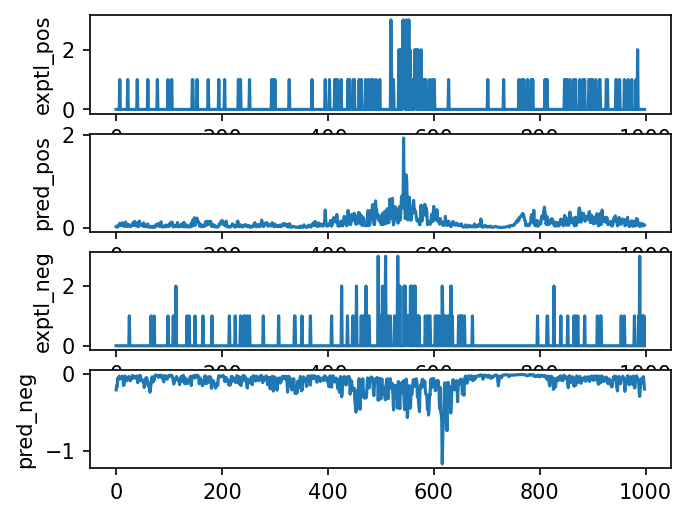

In [75]:
plotTfBigwigs('oct4', 'combined')

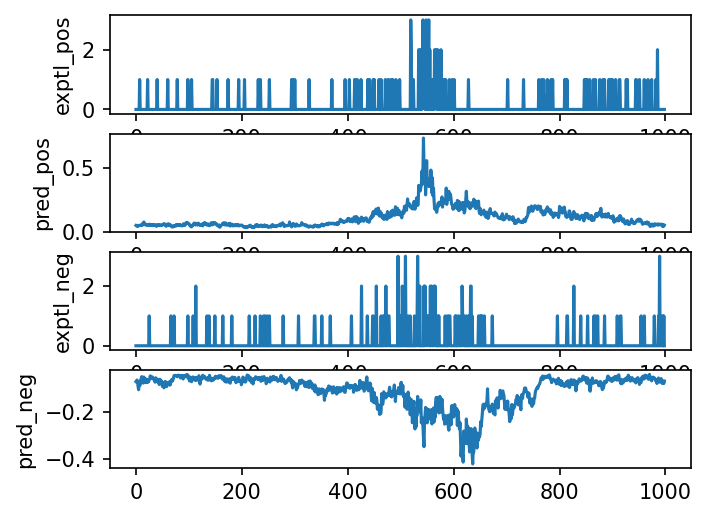

In [76]:
plotTfBigwigs('oct4', 'residual')

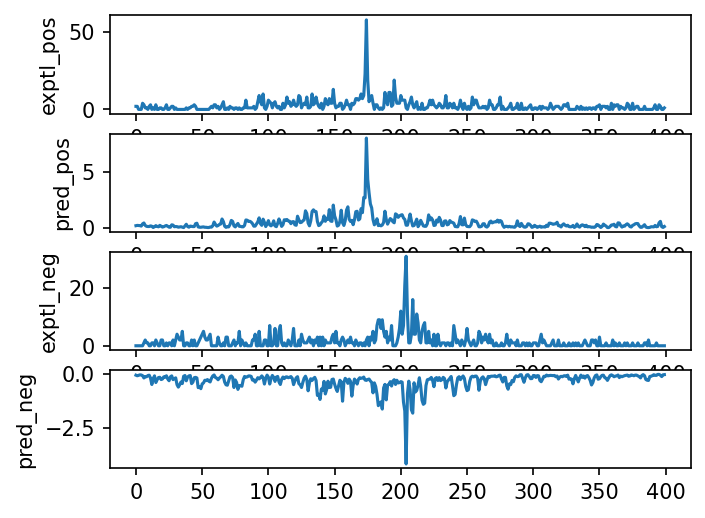

In [90]:
#Let's look around our favorite Lefty1 enhancer...
plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

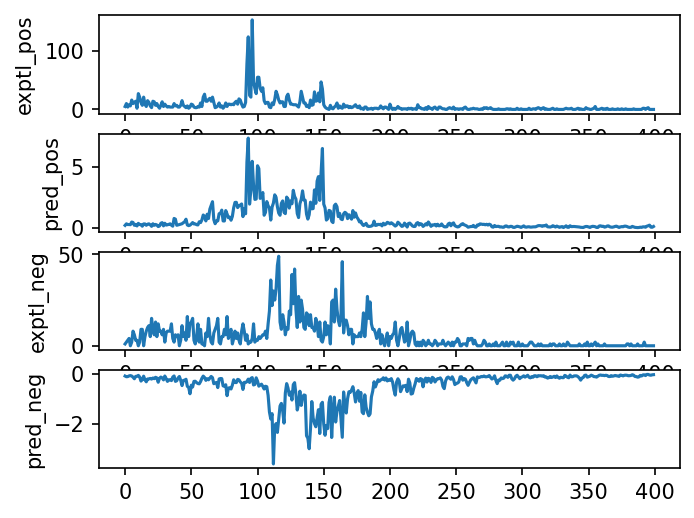

In [91]:
plotTfBigwigs('nanog', 'combined', startPos = 180924752, span=400)

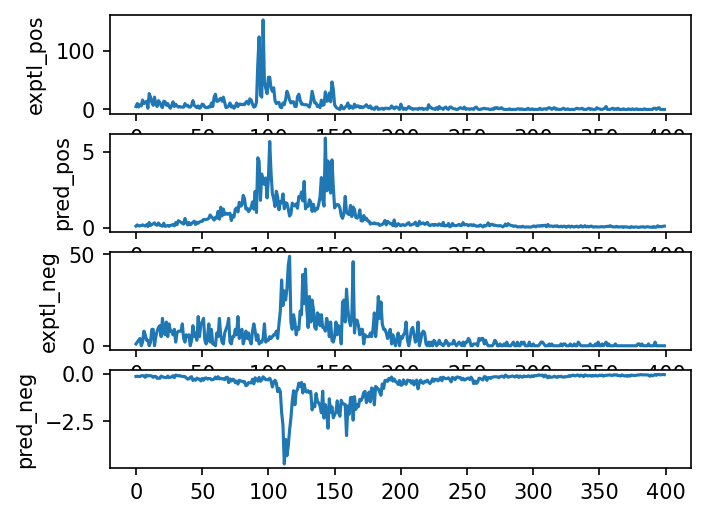

In [92]:
plotTfBigwigs('nanog', 'residual', startPos = 180924752, span=400)

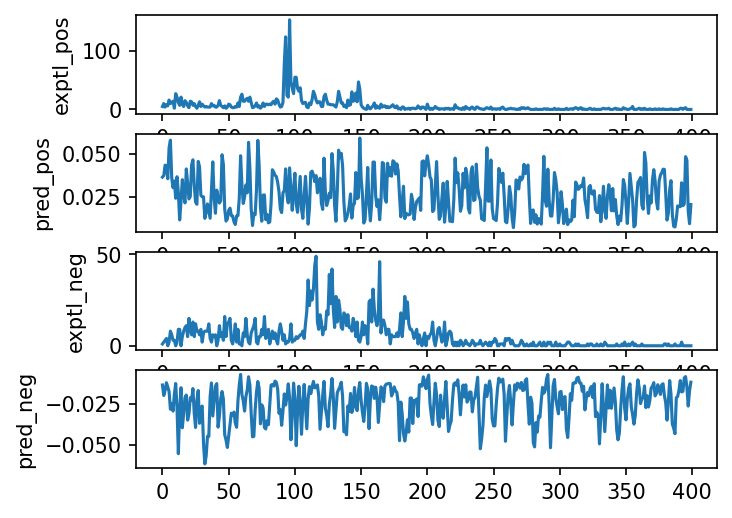

In [93]:
plotTfBigwigs('nanog', 'transform', startPos = 180924752, span=400)

# Deriving flat importance scores

In [109]:
#Importance scores are needed to run motif discovery, but they're also a great way to analyze what the model learned. 
#Unfortunately for us, they take a while to generate. 
def makeInterpretJson(tfNum):
    return {
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : 4,
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : "DEBUG"}

for tfNum in range(len(TF_NAMES)):
    with open(WORKING_DIRECTORY + "/json/shap_" + TF_NAMES[tfNum] + ".json", "w") as fp:
        json.dump(makeInterpretJson(tfNum), fp)
        

In [110]:
for tfName in TF_NAMES:
    !{SRC_DIR}/interpretFlat.py {WORKING_DIRECTORY}/json/shap_{tfName}.json

INFO:root:GPU memory growth enabled.


  0%|                                                 | 0/85120 [00:00<?, ?it/s]2022-10-21 16:30:55.152828: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
100%|███████████████████████████████████| 85120/85120 [1:37:38<00:00, 14.53it/s]
DEBUG:h5py._conv:Creating converter from 5 to 3
Tensor("strided_slice_3:0", shape=(None,), dtype=float32)
(None,)
100%|███████████████████████████████████| 85120/85120 [1:39:52<00:00, 14.20it/s]
INFO:root:GPU memory growth enabled.


  0%|                                                 | 0/85120 [00:00<?, ?it/s]2022-10-21 19:49:20.134426: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, whic

In [111]:
for tfName in TF_NAMES:
    for readout in ["profile", "counts"]:
        !{SRC_DIR}/shapToBigwig.py --h5 {WORKING_DIRECTORY}/shap/{tfName}_{readout}.h5 --bw {WORKING_DIRECTORY}/shap/{tfName}_{readout}.bw --verbose

INFO:root:Bigwig header[('chr1', 195471971), ('chr10', 130694993), ('chr11', 122082543), ('chr12', 120129022), ('chr13', 120421639), ('chr14', 124902244), ('chr15', 104043685), ('chr16', 98207768), ('chr17', 94987271), ('chr18', 90702639), ('chr19', 61431566), ('chr1_GL456210_random', 169725), ('chr1_GL456211_random', 241735), ('chr1_GL456212_random', 153618), ('chr1_GL456213_random', 39340), ('chr1_GL456221_random', 206961), ('chr2', 182113224), ('chr3', 160039680), ('chr4', 156508116), ('chr4_GL456216_random', 66673), ('chr4_GL456350_random', 227966), ('chr4_JH584292_random', 14945), ('chr4_JH584293_random', 207968), ('chr4_JH584294_random', 191905), ('chr4_JH584295_random', 1976), ('chr5', 151834684), ('chr5_GL456354_random', 195993), ('chr5_JH584296_random', 199368), ('chr5_JH584297_random', 205776), ('chr5_JH584298_random', 184189), ('chr5_JH584299_random', 953012), ('chr6', 149736546), ('chr7', 145441459), ('chr7_GL456219_random', 175968), ('chr8', 129401213), ('chr9', 124595110)

In [112]:
def plotShapBigwigs(tfName, exptName, startPos = 34066036, span=1000):
    plotBws([WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw",
             WORKING_DIRECTORY + "/shap/" + tfName + "_profile.bw", 
             WORKING_DIRECTORY + "/shap/" + tfName + "_counts.bw"],
            ["pred_pos", "pred_neg", "profile", "counts"], "chr1", startPos, startPos+span)

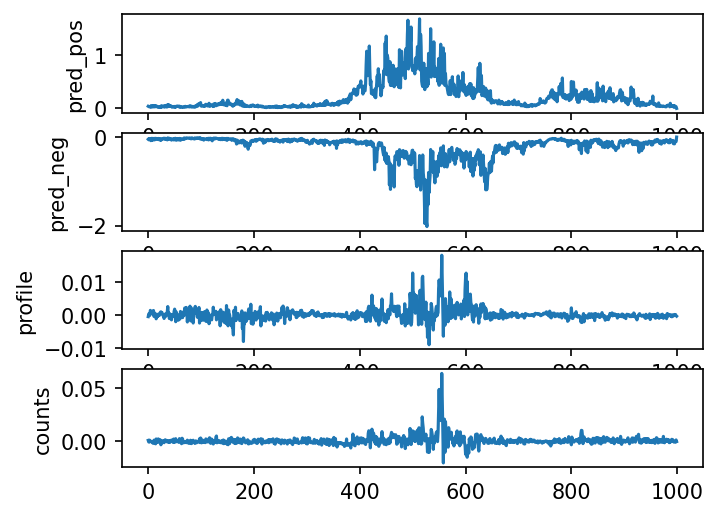

In [113]:
plotShapBigwigs("nanog", "residual")

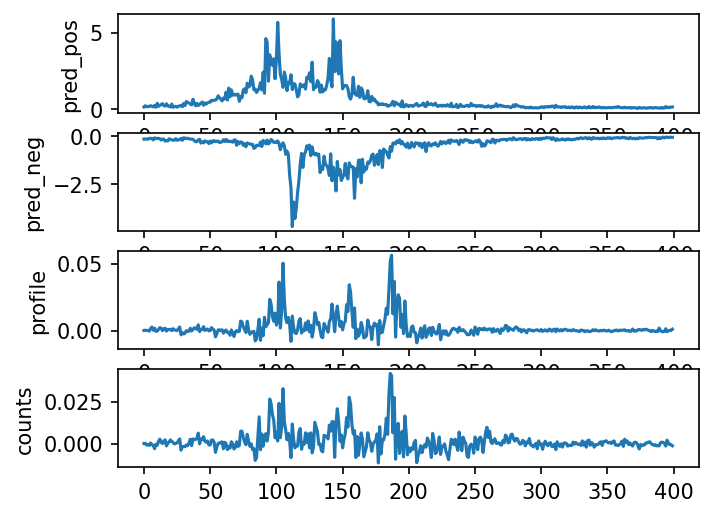

In [114]:
plotShapBigwigs('nanog', 'residual', startPos = 180924752, span=400)

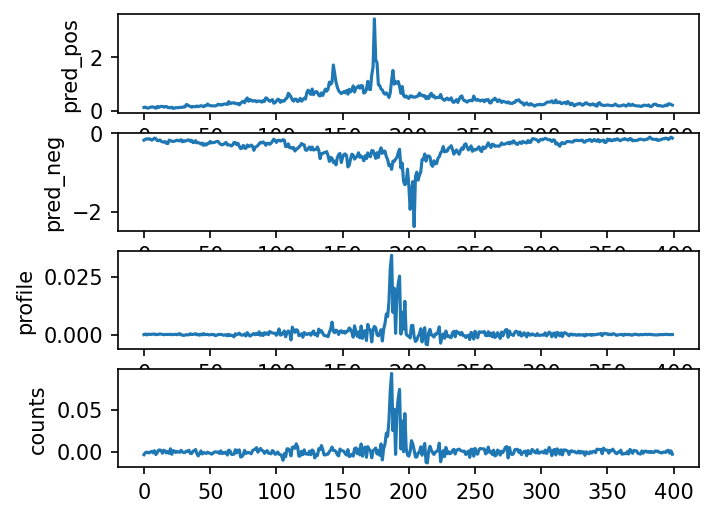

In [115]:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

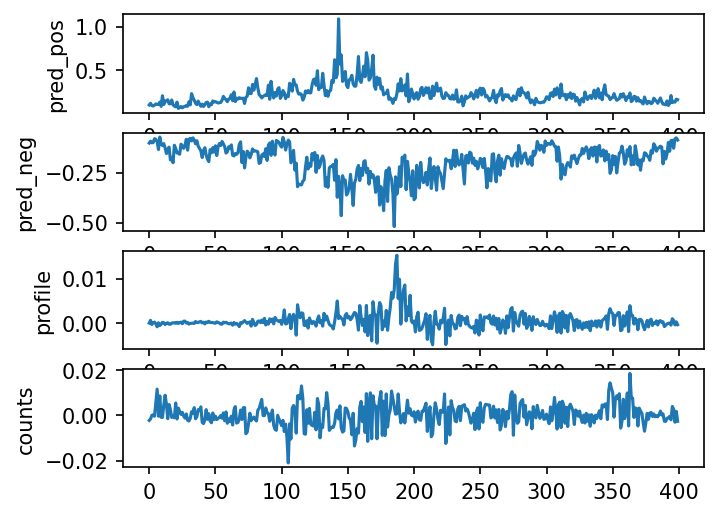

In [116]:
plotShapBigwigs('klf4', 'residual', startPos = 180924752, span=400)

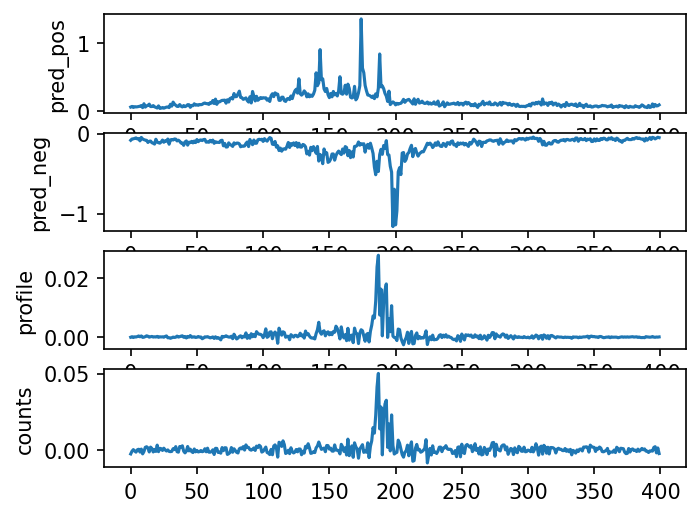

In [117]:
plotShapBigwigs('sox2', 'residual', startPos = 180924752, span=400)

In [158]:
#I'd like to know the distribution of importance scores. 
def plotHistogram(bwName, chrom, start, stop):
    fp = pyBigWig.open(bwName, "r")
    dats = np.array(fp.values(chrom, start, stop))
    fp.close()
    validDats = dats[~np.isnan(dats)]
    validDats = np.abs(validDats)
    validDats = np.log10(validDats)
    hist,edges = np.histogram(validDats, bins=100)
    plt.semilogy((edges[:-1] + edges[1:]) / 2, hist, '.')
    plt.xlabel("log10(importance)")
    plt.ylabel("Frequency")

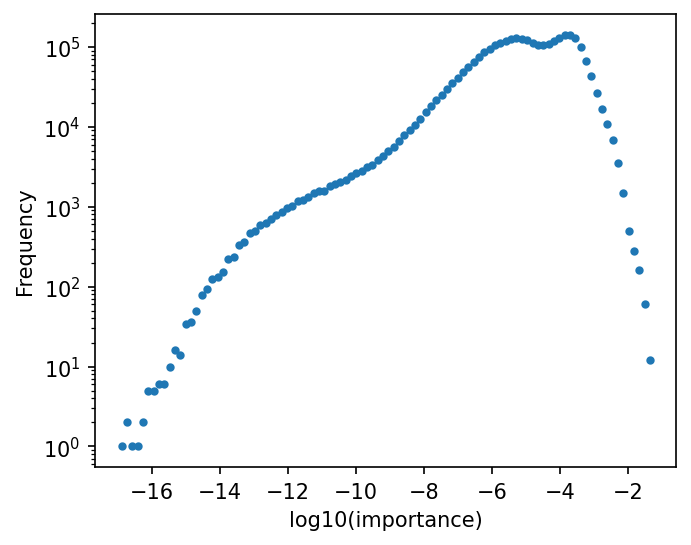

In [159]:
plotHistogram(WORKING_DIRECTORY + "/shap/oct4_profile.bw", "chr1", 10000000, 50000000)

In [162]:
#Great, so we have those bigwigs and the importance hdf5. I can run Modisco, but I'm going to use a non-GPU server for that. 
#Here's what the command would be, though:

MODISCO_WORKING_DIRECTORY = "/n/projects/cm2363/scratch/oskn-modisco"

for tf in TF_NAMES:
    for readout in ["counts", "profile"]:
        modiscoConfig = {"output-dir" : MODISCO_WORKING_DIRECTORY + "/modisco/" + tf + "_" + readout, 
                         "shap-h5" :    MODISCO_WORKING_DIRECTORY + "/shap/" + tf + "_" + readout + ".h5",
                         "center-cut-size" : 500,
                         "sliding-window-size" : 20,
                         "flank-size" : 5,
                         "num-cores" : 40, 
                         "target-seqlet-fdr" : 0.05,
                         "final-min-cluster-size" : 50,
                         "max-seqlets-per-metacluster" : 20000,
                         "verbosity" : "WARNING"}
        with open(MODISCO_WORKING_DIRECTORY + "/json/modisco_" + tf + "_" + readout + ".json", "w") as fp:
            json.dump(modiscoConfig, fp)
        #!{SRC_DIR}/runModisco.py {MODISCO_WORKING_DIRECTORY}/json/modisco_{tf}_{readout}.json

In [ ]:
#I'm not going further with MoDISco in this notebook, but there will be a hitmapping tool in the future. 

# Making a PISA plot

In [163]:
#In order to make a pisa plot, I need to get a list of regions I want to analyze. The way the PISA script works is that I give it a fasta-format file
#of genomic regions, each region being INPUT_LENGTH long. The PISA tool will then assign contributions to all of the bases in the input relative to the 
#*leftmost* base in the output. 
#This is important, so let me phrase it differently:



#|<- Receptive field ->|
#INPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCE
#\                     /                            /
#  \                 /                            /
#    \             /                            /
#      \         /                            /
#        \     /                            /
#          \ /                            /
#           OUTPUTPROFILEOUTPUTPROFILEOUTP
#           ^
#           | This O is the base that will be used to calculate the contribution scores. 
#It's important to not have any off-by-one problems here, so let's work it out manually. 
print(INPUT_LENGTH)
print(RECEPTIVE_FIELD)

3092
2092


In [165]:
#Since I don't feel like doing ascii art that's quite so wide, I'm going to say that the network is quite a bit smaller:
!{SRC_DIR}/lengthCalc.py --output-len 20 --n-dil-layers 3 --conv1-kernel-size 3 --profile-kernel-size 3

52


In [ ]:
#So in this example the receptive field would be 52-20+1=33. 
#And there are 16 bases of slop on each side that need to be seen by the model. 
#-30     -20       -10         0        10        20        30        40        50
#V         V         V         V         V         V         V         V         V
#098765432109876543210987654321012345678901234567890123456789012345678901234567890123456789
#Output:                       01234567890123456789
#Input:        6543210987654321012345678901234567890123456789012345
#Receptive:    654321098765432101234567890123456

#So in this case, if we want shap scores for a base at position zero, we need sequence from -16 to +35 (inclusive)

In [170]:
#So I need to get windows that are 3092 bases wide, and the first 2093 bases are the only ones that have a chance of affecting the output
#(since that's the receptive field for the first base.)
#The slop is (2093-1)/2 = 1046
#I want to shap starting at chr1:180924752 and I want to take 400 bases worth of calculations. 
def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - 1046
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch("chr1", genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")
windowStart = 180924752
with open(WORKING_DIRECTORY + "/shap/pisa_regions.fa", "w") as fp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowStart + 400):
            writeRegion(genome, fp, regionStart)
    


In [173]:
#And now we bulid the json file for the PISA analysis.

pisa_config = {"model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
               "sequence-fasta" : WORKING_DIRECTORY + "/shap/pisa_regions.fa", 
               "num-shuffles" : 20, 
               "head-id" : 3, #(That's the nanog head)
               "task-id" : 0,
               "output-h5" : WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
               "output-length" : OUTPUT_LENGTH,
               "make-predictions" : True,
               "verbosity" : "DEBUG"}

with open(WORKING_DIRECTORY + "/json/pisa_nanog_positive.json", "w") as fp:
    json.dump(pisa_config, fp)

In [ ]:
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : 4,
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : "DEBUG"}